In [18]:
# This notebook should be the centralized point for conformational analysis of Mpro trajectories.
# It allows for creating custom features based on certain atoms of certain residues.
# Then, we can look at histograms of all pairs of these features comparing to initial
# conformations.
# Next, we can re-structure those feature files to form a single trajectory of ALL features for
# each trajectory and use this as input for tICA.
# Through tICA, we can cluster the projection, create an MSM to assign populations, plot the
# projection (with cluster identities overlaid) and save the N closest frames to each
# cluster's center.

In [2]:
import itertools,glob,os,re
from tqdm import notebook
import mdtraj as md
import numpy as np

# Run this cell to compute and save distances for all the Apo crystal structures

for structure in notebook.tqdm(glob.glob('structures/ApoPDBs-desolv/*pdb')):
    ident = re.sub('.*desolv/','',re.sub('_apo-desolv.*','', structure)) # get the name
    try: # load in trajectory, skipping if files don't exist
        traj = md.load(structure)
    except Exception as e:
        continue
    
    # get several different groups of indices
    # most of the Apo PDBs are offset in index by 2 because of leading LIG/ACE on gro files
    PHE140_indices = [a.index for a in traj.topology.atoms if a.residue.index
      in [141-2] and a.name in ['CG','CD1','CD2','CE1','CE2','CZ'] and a.residue.name == 'PHE']
    HIS163_indices = [a.index for a in traj.topology.atoms if a.residue.index
      in [164-2] and a.name in ['CG','ND1','CD2','CE1','NE2'] and a.residue.name == 'HIS']
    CYS145_indices = [a.index for a in traj.topology.atoms if a.residue.index 
      in [146-2] and a.name in ['SG'] and a.residue.name == 'CYS']
    HIS41_indices = [a.index for a in traj.topology.atoms if a.residue.index
      in [42-2] and a.name in ['CG','ND1','CD2','CE1','NE2'] and a.residue.name == 'HIS']
    GLU166_indices = [a.index for a in traj.topology.atoms if a.residue.index
      in [167-2] and a.name in ['CD'] and a.residue.name == 'GLU']
    TYR126_indices = [a.index for a in traj.topology.atoms if a.residue.index
      in [127-2] and a.name in ['CG','CZ','CE1','CE2','CD1','CD2'] and a.residue.name == 'TYR']
    all_indices = [PHE140_indices,HIS163_indices,CYS145_indices,HIS41_indices,
        GLU166_indices,TYR126_indices]

    # for each combination of these index pairs, compute atom index pairs, distances, labels,
    # and save distances to a directory
    try:
        for x,i in enumerate(all_indices):
            for y,j in enumerate(all_indices):
                if i != j and x<y:
                    pairs = list(itertools.product(i,j))
                    feature_labels = [[[str(2+traj.topology.atom(z[0]).residue.index) +
                        traj.topology.atom(z[0]).residue.name,traj.topology.atom(z[0]).name],
                      [str(2+traj.topology.atom(z[1]).residue.index) + 
                       traj.topology.atom(z[1]).residue.name,traj.topology.atom(z[1]).name]
                        ] for z in pairs]
                    feature_directory = f'Features/{feature_labels[0][0][0]}_{feature_labels[0][1][0]}'
                    distances = md.compute_distances(traj,pairs)
                    np.save(f'{feature_directory}/{ident}.npy',distances)
    except Exception as e:
        print(f'{ident} Failed to find all residues:', e)
        continue

  0%|          | 0/587 [00:00<?, ?it/s]

Mpro-z7kvg_0A Failed to find all residues: list index out of range
Mpro-z7l10_0A Failed to find all residues: list index out of range
Mpro-z3d23_0D Failed to find all residues: list index out of range
Mpro-z4ylu_0A Failed to find all residues: list index out of range
Mpro-z4ylu_0B Failed to find all residues: list index out of range
Mpro-z4ylu_0C Failed to find all residues: list index out of range
Mpro-z4ylu_0D Failed to find all residues: list index out of range
Mpro-z6jij_0A Failed to find all residues: list index out of range
Mpro-z6jij_0B Failed to find all residues: list index out of range
Mpro-z6jij_0C Failed to find all residues: list index out of range
Mpro-z2q6g_0A Failed to find all residues: list index out of range
Mpro-z2q6g_0B Failed to find all residues: list index out of range
Mpro-z2zu2_0A Failed to find all residues: list index out of range
Mpro-z2zu2_0B Failed to find all residues: list index out of range
Mpro-z2zu2_1A Failed to find all residues: list index out of r

In [1]:
import itertools,glob,os,re
from tqdm import notebook
import mdtraj as md
import numpy as np

# Run this cell to compute and save distances (takes about five minutes as is)
# and generates about 700MB of feature data

for directory in notebook.tqdm(glob.glob('Trajectories/*')):
    ident = re.sub('.*P','P',directory) # get just the PROJ_RUN_CLONE identifier
    try: # load in trajectory, skipping if files don't exist
        traj = md.load(f'{directory}/traj.xtc',top=f'{directory}/xtc.gro')
    except Exception as e:
        continue
        
    # get several different groups of indices
    PHE140_indices = [a.index for a in traj.topology.atoms if a.residue.index
      in [141] and a.name in ['CG','CD1','CD2','CE1','CE2','CZ']]
    HIS163_indices = [a.index for a in traj.topology.atoms if a.residue.index
      in [164] and a.name in ['CG','ND1','CD2','CE1','NE2']]
    CYS145_indices = [a.index for a in traj.topology.atoms if a.residue.index 
      in [146] and a.name in ['SG']]
    HIS41_indices = [a.index for a in traj.topology.atoms if a.residue.index
      in [42] and a.name in ['CG','ND1','CD2','CE1','NE2']]
    GLU166_indices = [a.index for a in traj.topology.atoms if a.residue.index
      in [167] and a.name in ['CD']]
    TYR126_indices = [a.index for a in traj.topology.atoms if a.residue.index
      in [127] and a.name in ['CG','CZ','CE1','CE2','CD1','CD2']]
    all_indices = [PHE140_indices,HIS163_indices,CYS145_indices,HIS41_indices,
        GLU166_indices,TYR126_indices]
    
    # for each combination of these index pairs, compute atom index pairs, distances, labels,
    # and save distances/feature_labels to a directory
    for x,i in enumerate(all_indices):
        for y,j in enumerate(all_indices):
            if i != j and x<y:

                pairs = list(itertools.product(i,j))
                feature_labels = [[[str(traj.topology.atom(z[0]).residue.index) +
                    traj.topology.atom(z[0]).residue.name,traj.topology.atom(z[0]).name],
                  [str(traj.topology.atom(z[1]).residue.index) + 
                   traj.topology.atom(z[1]).residue.name,traj.topology.atom(z[1]).name]
                    ] for z in pairs]
                
                feature_directory = f'Features/{feature_labels[0][0][0]}_{feature_labels[0][1][0]}'
                # skip if we've already processed these features for this trajectory
                if os.path.exists(f'{feature_directory}/{ident}.npy'):
                    continue
                distances = md.compute_distances(traj,pairs)

                if not os.path.exists(f'{feature_directory}/feature_labels.npy'):
                    try:
                        os.makedirs(feature_directory)
                        np.save(f'{feature_directory}/feature_labels.npy',feature_labels)
                    except Exception as e:
                        np.save(f'{feature_directory}/feature_labels.npy',feature_labels)
                np.save(f'{feature_directory}/{ident}.npy',distances)
                


        


  0%|          | 0/870 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

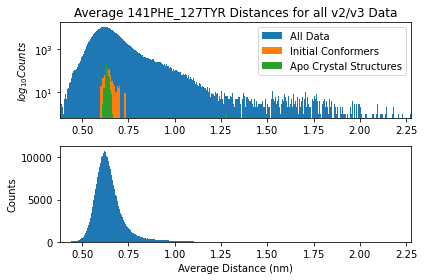

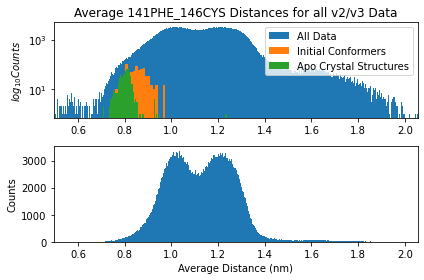

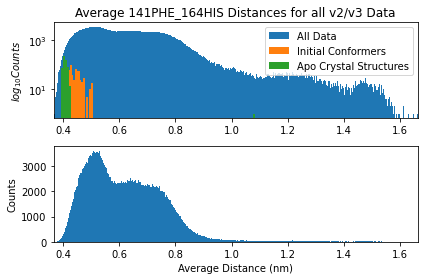

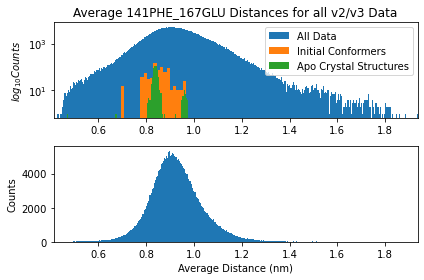

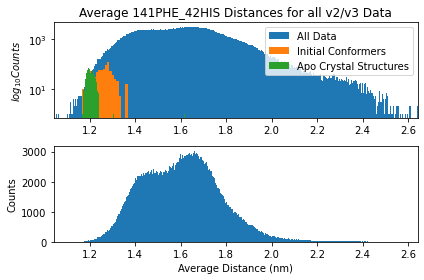

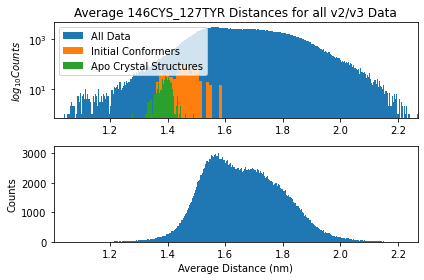

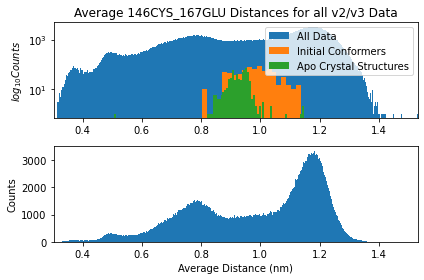

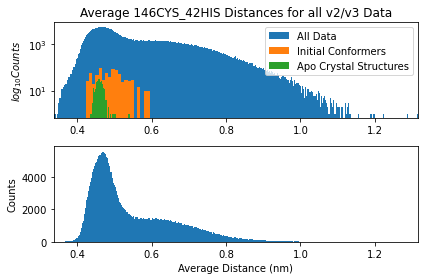

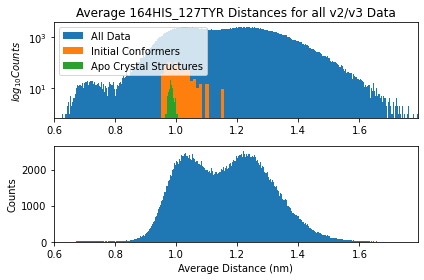

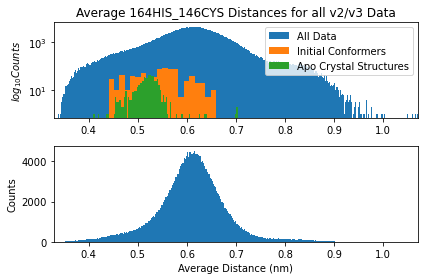

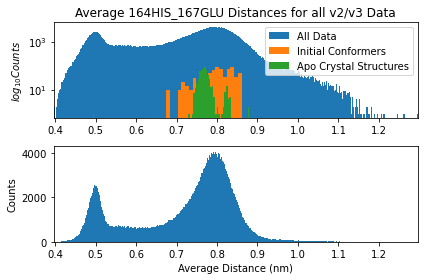

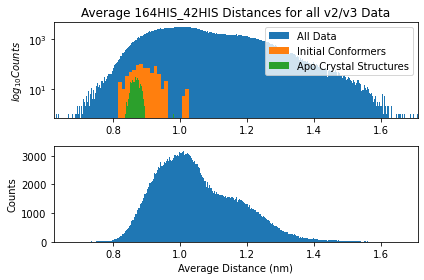

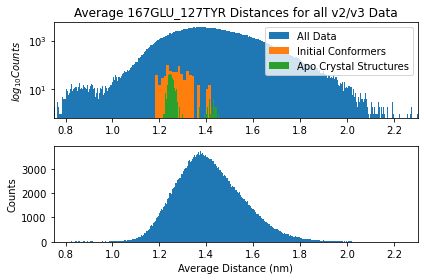

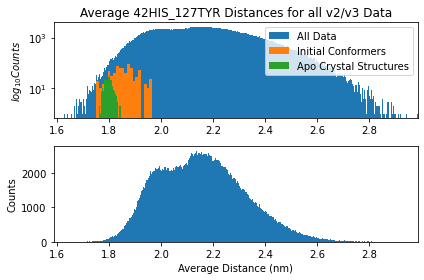

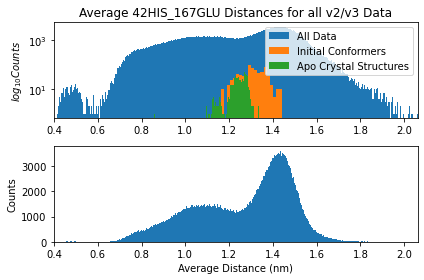

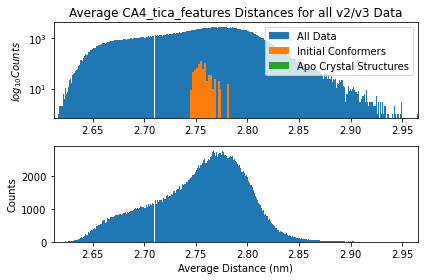

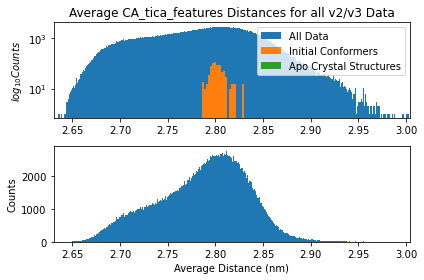

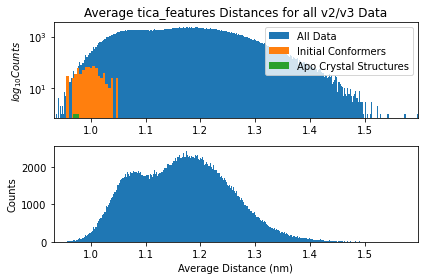

In [9]:
from tqdm import notebook
import glob, re, os
import numpy as np
from matplotlib import pyplot as plt

# This will make histograms for each of the previously extracted features
# with another histogram projected on top for features of initial conformers
save_plots = False

for directory in notebook.tqdm(glob.glob('Features/*')):
    feature_name = re.sub('Features/','',directory)
    xtal, distances = [],[]
    for file in glob.glob(f'{directory}/P14*'):
        distances.append(np.load(file))
    # distances will be of shape (nTrajectories, nFrames, nDistances)
    # we can take the average of these distances for each frame to get an idea of
    # overall residue to residue changes
    average_distances, first_frame_averages = [],[]
    for i in distances: # for each traj
        for x,j in enumerate(i): # for each frame
            if x == 0:
                first_frame_averages.append(np.average(j))
            average_distances.append(np.average(j))
    for file in glob.glob(f'{directory}/Mpro*'):
        xtal.append(np.average(np.load(file)[0]))
    plt.subplot(211)
    # make a histogram for each feature with an overlayed histogram of initial distances
    plt.hist(average_distances,bins=1000, label='All Data')
    plt.hist(first_frame_averages,bins=20, label='Initial Conformers')
    plt.hist(xtal,bins=100, label='Apo Crystal Structures')
    plt.legend()
    plt.title(f'Average {feature_name} Distances for all v2/v3 Data')
    plt.ylabel('$log_{10} Counts$')
    plt.yscale('log')
    plt.xlim(min(average_distances), max(average_distances))
    plt.subplot(212)
    plt.hist(average_distances,bins=1000, label='All Data')
    plt.xlabel('Average Distance (nm)')
    plt.ylabel('Counts')
    plt.xlim(min(average_distances), max(average_distances))
    plt.tight_layout()
    if save_plots:
        if not os.path.exists('plots'):
            os.makedirs('plots')
        plt.savefig(f'plots/{feature_name}_hist.png')
    else:
        plt.show()
    plt.close()

In [112]:
from tqdm import notebook
import glob, os, re
import numpy as np

# This creates an overall feature file for each trajectory, basically re-structuring
# the files in Features to go by trajectory instead of feature.
# This generates another ~700MB of data since it just changes the shape of the other files.

featurize_traj = True
featurize_apo = True
if not os.path.exists(f'Features/tica_features'):
    os.makedirs(f'Features/tica_features')

feature_labels = [] # this contains descriptions of each feature
features = [] # this will contain all features for all frames for each trajectory
feature_directories = [x for x in glob.glob('Features/*') if 'features' not in x]

if featurize_traj:
    for x,directory in notebook.tqdm(enumerate(glob.glob('Trajectories/*'))):

        ident = re.sub('.*P','P',directory)
        # go through each of the feature sets for that trajectory
        all_traj_features = []
        for feature_directory in feature_directories:
            # obviously don't process already processed tica features if they exist.
            feature_name = re.sub('Features/','', feature_directory)
            if 'features' in feature_name:
                continue
            if x == 0:
                feature_labels += list(np.load(f'{feature_directory}/feature_labels.npy'))

            if os.path.exists(f'{feature_directory}/{ident}.npy'):
                all_traj_features.append(np.load(f'{feature_directory}/{ident}.npy'))
            else:
                continue

        # put all the features together into a single array for each trajectory and save
        try:
            np.save(f'Features/tica_features/{ident}.npy',np.concatenate(all_traj_features, axis=1))
        except Exception as e:
            continue
        
if featurize_apo:
    all_apo = []
    for x,directory in notebook.tqdm(enumerate(glob.glob('structures/ApoPDBs-desolv/*pdb'))):
        ident = re.sub('.*desolv/','',re.sub('_apo-desolv.*','', directory))
        # go through each of the feature sets for that trajectory
        pdb_features = []
        for feature_directory in feature_directories:
            # obviously don't process already processed tica features if they exist.
            feature_name = re.sub('Features/','', feature_directory)
            if 'features' in feature_name:
                continue

            if os.path.exists(f'{feature_directory}/{ident}.npy'):
                pdb_features.append(np.load(f'{feature_directory}/{ident}.npy')[0])
            else:
                continue


        # put all the features together into a single array for each trajectory and save

        if len(pdb_features) == len(feature_directories):
            all_apo.append(np.concatenate(pdb_features,axis=0))
    np.save(f'Features/tica_features/Mpro.npy', all_apo)



np.save(f'Features/tica_features/feature_labels.npy', feature_labels)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [42]:
# This cell contains function defintions from Tim's code for performing tICA
# Look to the cell below for actually performing tICA and outputting relevant structures.

def tica(features, lag_time, save, save_dir, save_name):
    tica = pyemma.coordinates.tica(features, dim=8, lag=lag_time, stride=1, kinetic_map=True, commute_map=False)
    if save == True:
        tica.save(f'{save_dir}/tica_raw.h5', overwrite=True)
        np.save(f'{save_dir}/tica_output.npy', tica.get_output())
    return tica

def k_means(tica_getoutput, n_cluster, max_iter, save, save_dir, save_name):
    cluster = pyemma.coordinates.cluster_kmeans(tica_getoutput, k=n_cluster, max_iter=max_iter)
    cluster_getoutput = cluster.get_output()
    cluster_dtrajs = cluster.dtrajs
    cluster_centers = cluster.clustercenters
    if save == True:
        cluster.save(f'{save_dir}/{n_clusters}_clusters_raw.h5', overwrite=True)
        np.save(f'{save_dir}/{n_clusters}_clusters_output.npy', cluster_getoutput)
        np.save(f'{save_dir}/{n_clusters}_clusters_dtrajs.npy', cluster_dtrajs)
        np.save(f'{save_dir}/{n_clusters}_clusters_centers.npy', cluster_centers)
    return cluster, cluster_centers, cluster_dtrajs

def generate_msm(cluster, n_cluster, msm_lag, save, save_dir, save_name):
    msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, msm_lag)
    if save == True:
        state_frac_used = msm.active_state_fraction
        count_frac_used = msm.active_count_fraction
        feat_act_set = msm.active_set
        eigvec = msm.eigenvectors_right()
        msm.save(f'{save_dir}/{n_cluster}_clusters_msm_raw.h5',  overwrite=True)
    return msm

def find_cluster_center_structures(cluster_centers, tica_output, npdbs):
    pdb_ndxs, min_distance_frames = [],[]
    coordinates = np.concatenate(tica_output)
    # create a distance matrix from every center to every tica frame
    distances = distance_matrix(cluster_centers, coordinates)
    
    for j in range(len(cluster_centers)):
        # determine tica frames of min distance
        min_distance_frames.append(
          pd.Series(distances[j]).nsmallest(npdbs).index.values.tolist())
        # ensure we do not see these frame again
        distances[:,min_distance_frames[-1]] = 1e9
        
        # return which trajectory/frame index each came from
        pdb_ndxs.append([])
        for frame in min_distance_frames[-1]:
            traj_ndx = 0
            for clone in tica_output:
                if frame > len(clone):
                    traj_ndx += 1
                    frame -= len(clone)
                else:
                    pdb_ndxs[-1].append([traj_ndx,frame])
                    break
                    
    return np.asarray(min_distance_frames), pdb_ndxs

def visualize_tics(tica_output, components=[[0,1]], frames=16, custom_spline=0):
    # visualize a trajectory along the first component listed in components.
    # The projection will be plotted against the second component in components.
    colors = plt.get_cmap('rainbow')(np.linspace(0,1,frames))
    coordinates = np.concatenate(tica_output)
    
    for i in components:
        print(f'Creating visualization of tIC{i[0]+1}')
        # define a linear spacing along the tIC
        if isinstance(custom_spline, int):
            x = np.linspace(min(coordinates[:,i[0]]),max(coordinates[:,i[0]]),frames)
            cluster_centers = np.zeros((frames,8))
            cluster_centers[:,i[0]] = x
        else:
            cluster_centers = custom_spline
        colors = plt.get_cmap('rainbow')(np.linspace(0,1,len(cluster_centers)))
        # determine the closest frame to each point
        min_distance_frames, pdb_ndxs = find_cluster_center_structures(cluster_centers, tica_output, npdbs=1)

        # plot the projections with the chosen frames superimposed
        plt.figure(figsize = (9,8))
        plt.hexbin(coordinates[:,i[0]],coordinates[:,i[1]], bins='log')
        plt.scatter(coordinates[:,i[0]][min_distance_frames[:,0]],
          coordinates[:,i[1]][min_distance_frames[:,0]], color=colors)
        plt.title(f'tICA Visualization Trajectory')
        plt.xlabel(f'tIC{i[0]+1}')
        plt.ylabel(f'tIC{i[1]+1}')
        plt.tight_layout()
        if save_plots:
            plt.savefig(f'{tica_dir}/plots/tIC{i[0]+1}-{i[1]+1}_vis.png')
        else:
            plt.show()
        plt.close()
        
        tic_frames, names = [],[]
        # load in each of the frames
        for j in range(len(min_distance_frames)):
            traj_file = f'Trajectories/{traj_files[pdb_ndxs[j][0][0]]}/traj.xtc'
            gro_file = f'Trajectories/{traj_files[pdb_ndxs[j][0][0]]}/xtc.gro'
            try:
                frame = md.load_frame(traj_file, pdb_ndxs[j][0][1], top=gro_file)
            except Exception as e:
                traj = md.load(traj_file, top=gro_file)
                print('Failed to load Frame..\n', e, traj)
                
                continue
            indices = [a.index for a in frame.topology.atoms if a.residue.name != 'LIG']
            tic_frames.append(frame.atom_slice(indices))
            names.append([a.name for a in frame.topology.atoms if a.index in indices])

        # find the largest subset of frames that share the same atom ordering
        names = tuple([tuple(x) for x in names])
        good_names = list(Counter(names).most_common(1)[0][0])
        good_frame_ndxs = [x for x,y in enumerate(names) if list(y) == good_names]
        good_frames = [tic_frames[x] for x in good_frame_ndxs]

        # join them into a single trajectory and save gro/xtc
        traj = md.join(good_frames)
        traj[0].save_gro(f'{tica_dir}/tIC_visualization/tIC{i[0]+1}-{i[1]+1}.gro')
        traj.save_xtc(f'{tica_dir}/tIC_visualization/tIC{i[0]+1}-{i[1]+1}.xtc')

    
def eigenvector_analysis(tica_obj, features, labels, n_top_features=8, n_tics=4):
    # get the eigenvectors
    vecs = np.transpose(tica_obj.eigenvectors)
    # get the std of each distance feature
    feature_variance = [np.std(np.concatenate(features)[:,x]) for x in range(len(vecs[0]))]

    plt.figure(figsize=(16,5))
    for tic in range(n_tics): # for each of the first 4 components
        plt.subplot(1,4,tic+1)
        # normalize using 1/sigma and find n features of max magnitude
        norm_vec = np.asarray([vecs[tic][x] * feature_variance[x] for x in range(len(vecs[tic]))])
        norm_abs_vec = pd.Series(abs(norm_vec))
        top_feature_indices = norm_abs_vec.nlargest(n_top_features).index.values.tolist()
        plt.bar(range(n_top_features), norm_vec[top_feature_indices])
        plt.xticks(range(n_top_features),
          [f"{'_'.join(labels[x][0])} - {'_'.join(labels[x][1])}" for x in top_feature_indices],
          rotation=90)
        plt.title(f'tIC{tic+1} Top Features')
    plt.suptitle(f'Top Normalized Features')
    plt.tight_layout()

    if save_plots:
        plt.savefig(f'{tica_dir}/plots/normalized_eigenvectors.png')
    else:
        plt.show()
    plt.close()


calculate covariances:   0%|                                                       | 0/295 [00:00<?, ?it/s]

getting output of TICA:   0%|                                                      | 0/295 [00:00<?, ?it/s]

/home/matt/packages/miniconda3/envs/pyem/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


getting output of TICA:   0%|                                                      | 0/295 [00:00<?, ?it/s]

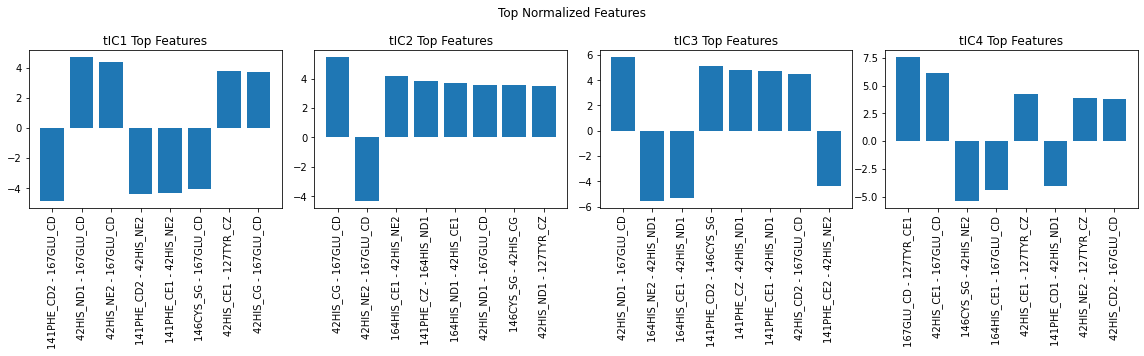

Creating visualization of tIC1
Creating visualization of tIC2
Creating visualization of tIC3
Creating visualization of tIC4


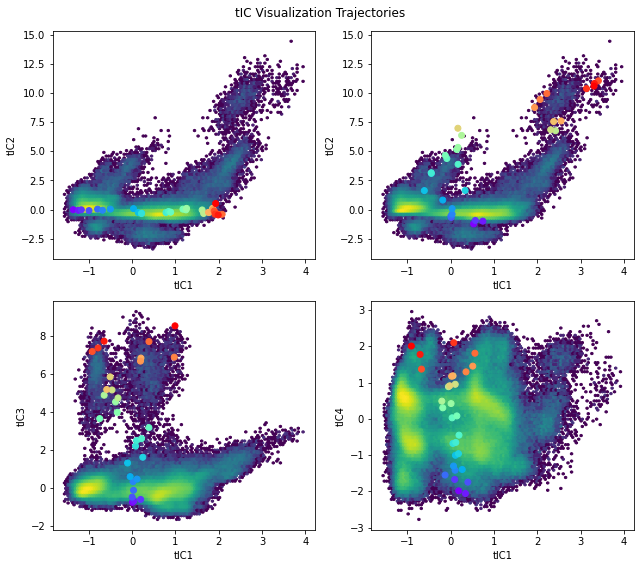

initialize kmeans++ centers:   0%|                                                   | 0/8 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                           | 0/100 [00:00<?, ?it/s]

getting output of KmeansClustering:   0%|                                          | 0/295 [00:00<?, ?it/s]

getting output of KmeansClustering:   0%|                                          | 0/295 [00:00<?, ?it/s]

/home/matt/packages/miniconda3/envs/pyem/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Saving 5 closest frames to each cluster...


/tmp/ipykernel_16434/2852364768.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  coordinates = np.concatenate(np.asarray(tica_output))


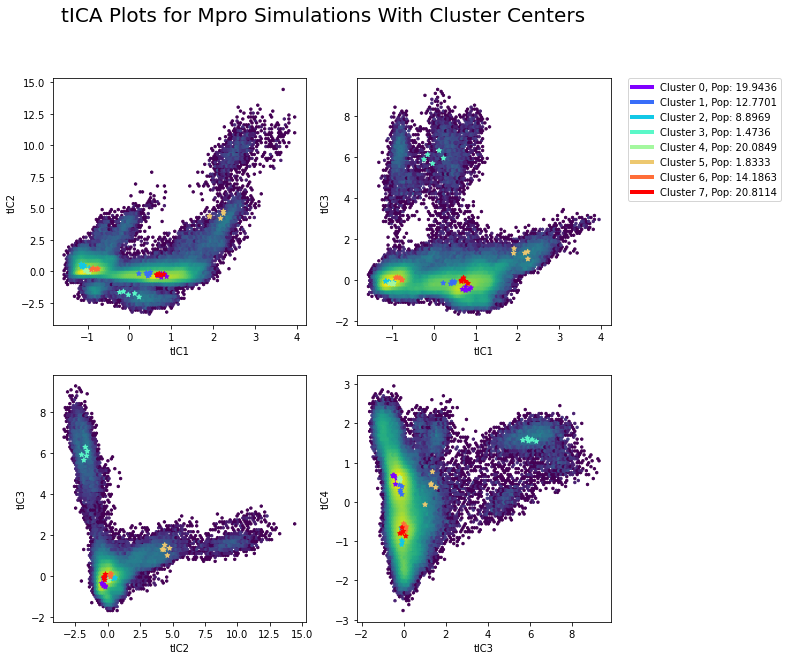

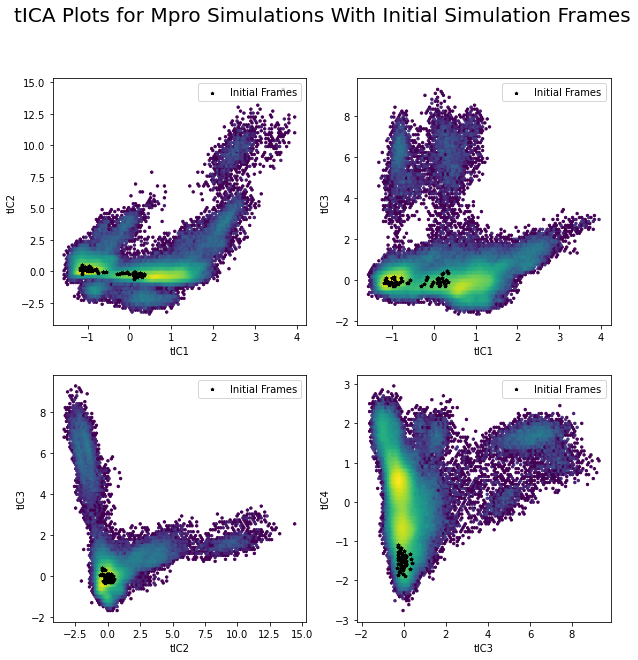

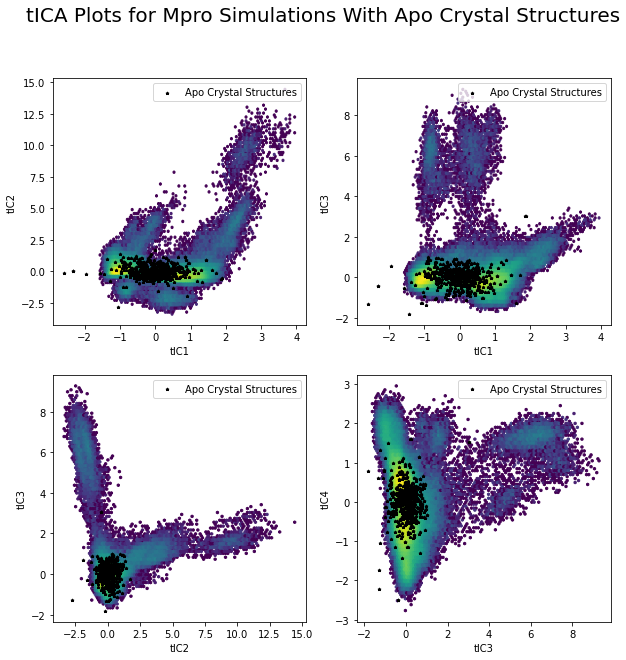

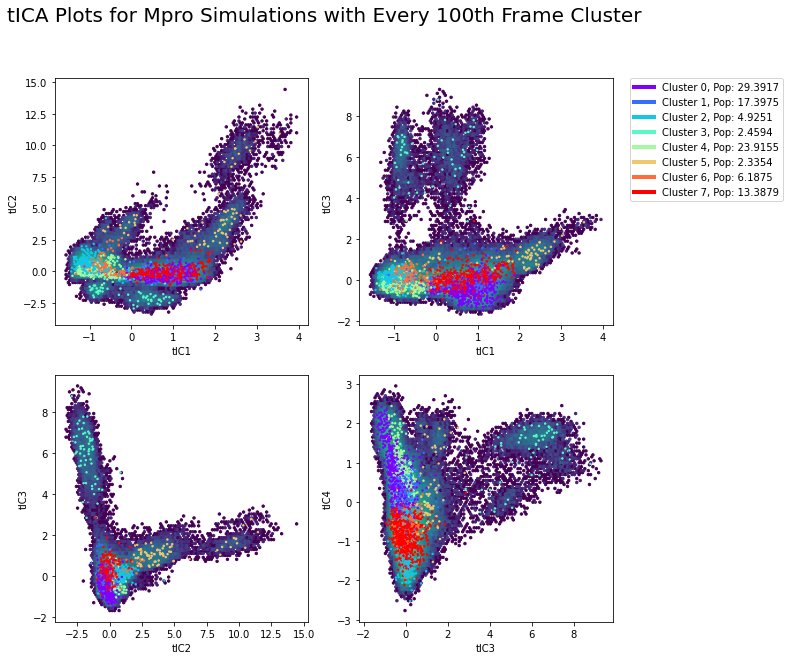

/tmp/ipykernel_16434/2852364768.py:171: RuntimeWarning: divide by zero encountered in log10
  mat = ax.matshow(np.log10(msm.P), interpolation='nearest')
/tmp/ipykernel_16434/2852364768.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+labels)
/tmp/ipykernel_16434/2852364768.py:174: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+labels)
/tmp/ipykernel_16434/2852364768.py:181: RuntimeWarning: divide by zero encountered in log
  mfpt_mat[i][j] = np.log(msm.mfpt(i,j))
/tmp/ipykernel_16434/2852364768.py:187: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+labels)
/tmp/ipykernel_16434/2852364768.py:188: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+labels)


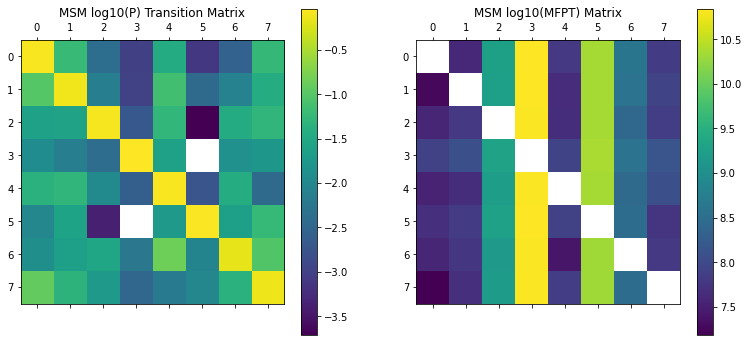

In [19]:
import glob, os, re
import pyemma
import mdtraj as md
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from collections import Counter
from scipy.spatial import distance_matrix

# This cell loads in all the tICA-ready feature data, performs tICA, clusters in 
# tICA-space, plots tICA projections, creates an MSM to estimate populations, and
# outputs structures for each cluster center

tica_dir = 'pocket-tica-v3' # directory to save results
feature_type='distances' # description of features
tica_lagtime = 100
n_components = 8
n_clusters = 8
msm_lagtime = 100
n_pdbs_to_save = 5 # per cluster
save_plots = False

# create some directories for output files
for sub_dir in ['plots', 'structures', 'objects', 'tIC_visualization']:
    if not os.path.exists(f'{tica_dir}/{sub_dir}'):
        os.makedirs(f'{tica_dir}/{sub_dir}')

features, traj_files = [],[]
feature_labels = np.load('Features/tica_features/feature_labels.npy')

# load in all the tica-ready featured data
for feature_file in glob.glob(f'Features/tica_features/P148*'):
    if 'feature_labels' in feature_file:
        continue
    ident = re.sub('.npy','',re.sub('.*tica_features/','',feature_file))
    traj_files.append(ident)
    features.append(np.load(feature_file))
    

# performing tICA
tica_obj = tica(features, tica_lagtime, save=True,
  save_dir=f'{tica_dir}/objects', save_name=feature_type)
tica_output = tica_obj.get_output()
# fit the apo crystal data to our projection
apo_tica = tica_obj.fit_transform(np.load('Features/tica_features/Mpro.npy'))

# analyze eigenvectors to pick out top features
eigenvector_analysis(tica_obj, features, feature_labels)

# create trajectories along each of the tICs over 100 evenly spaced frames
visualize_tics(tica_output, frames=100, components=[[0,1],[1,0],[2,0],[3,0]])

# clustering in tICA space
cluster, cluster_centers, cluster_dtrajs = k_means(tica_output, n_clusters,
  max_iter=100, save=True, save_dir=f'{tica_dir}/objects', save_name=feature_type)
c = Counter(np.concatenate(cluster_dtrajs))
pops = [c[x]/len(np.concatenate(cluster_dtrajs)) for x in range(n_clusters)]

# generating MSM from tICA projection
msm = generate_msm(cluster, n_clusters, msm_lagtime, save=True,
  save_dir=f'{tica_dir}/objects', save_name=feature_type)

# saving pdbs for each cluster center
print(f'Saving {n_pdbs_to_save} closest frames to each cluster...')
center_frames, pdb_ndxs = find_cluster_center_structures(cluster_centers, tica_output,
  npdbs=n_pdbs_to_save)

for i in range(n_clusters):
    pop = int(pops[i]*100)
    for j in range(n_pdbs_to_save):
        traj_file = f'Trajectories/{traj_files[pdb_ndxs[i][j][0]]}/traj.xtc'
        gro_file = f'Trajectories/{traj_files[pdb_ndxs[i][j][0]]}/xtc.gro'
        frame = md.load_frame(traj_file, pdb_ndxs[i][j][1], top=gro_file)
        frame.save_pdb(f'{tica_dir}/structures/{traj_files[pdb_ndxs[i][j][0]]}_f{pdb_ndxs[i][j][1]}_c{i}_p{pop}.pdb')

# making & saving plots of tICA projections
coordinates = np.concatenate(np.asarray(tica_output))
cluster_colors = plt.get_cmap('rainbow')(np.linspace(0,1,n_clusters))
stride = 100
colors = [cluster_colors[c] for c in np.concatenate(cluster_dtrajs)[::stride]]
center_colors = [cluster_colors[c] for c in np.concatenate(cluster_dtrajs)[center_frames]]
legend_lines = [Line2D([0], [0], color=c, lw=4) for c in cluster_colors]

# plot tICA projection with cluster centers 
plt.figure(figsize=(10,10))
plt.suptitle(f'tICA Plots for Mpro Simulations With Cluster Centers', size=20)
for x,dims in enumerate([[0,1],[0,2],[1,2],[2,3]]):
    X = coordinates[:,dims[0]]
    Y = coordinates[:,dims[1]]
    plt.subplot(2,2,x+1)
    plt.hexbin(X, Y, bins='log')
    plt.scatter(np.concatenate(X[center_frames]), np.concatenate(Y[center_frames]),
      color=np.concatenate(center_colors), marker='*', s=24)
    if x == 1:
      plt.legend(legend_lines, [f'Cluster {n}, Pop: {pops[n]*100:.4f}'
        for n in range(n_clusters)], bbox_to_anchor=(1.05, 0.82, 0.3, 0.2), loc='upper left')
    plt.xlabel(f'tIC{dims[0]+1}')
    plt.ylabel(f'tIC{dims[1]+1}')
if save_plots:
    plt.savefig(f'{tica_dir}/plots/tica.png')
else:
    plt.show()
plt.close()

# plot initial simulation frames over the tICA projection
plt.figure(figsize=(10,10))
plt.suptitle(f'tICA Plots for Mpro Simulations With Initial Simulation Frames', size=20)
for x,dims in enumerate([[0,1],[0,2],[1,2],[2,3]]):
    X = coordinates[:,dims[0]]
    Y = coordinates[:,dims[1]]
    plt.subplot(2,2,x+1)
    plt.hexbin(X, Y, bins='log')
    for i in tica_output:
        plt.scatter(i[:,dims[0]][0], i[:,dims[1]][0], marker='*', color='k', s=8)
    plt.scatter(i[:,dims[0]][0], i[:,dims[1]][0], marker='*', color='k', s=8,
      label='Initial Frames')
    plt.xlabel(f'tIC{dims[0]+1}')
    plt.ylabel(f'tIC{dims[1]+1}')
    plt.legend()
if save_plots:
    plt.savefig(f'{tica_dir}/plots/tica_initial.png')
else:
    plt.show()
plt.close()

# plot apo crystal structures over the tICA projection
plt.figure(figsize=(10,10))
plt.suptitle(f'tICA Plots for Mpro Simulations With Apo Crystal Structures', size=20)
for x,dims in enumerate([[0,1],[0,2],[1,2],[2,3]]):
    X = coordinates[:,dims[0]]
    Y = coordinates[:,dims[1]]
    plt.subplot(2,2,x+1)
    plt.hexbin(X, Y, bins='log')
    plt.scatter(apo_tica[:,dims[0]], apo_tica[:,dims[1]], marker='*', color='k', s=8,
      label='Apo Crystal Structures')
    plt.xlabel(f'tIC{dims[0]+1}')
    plt.ylabel(f'tIC{dims[1]+1}')
    plt.legend()
if save_plots:
    plt.savefig(f'{tica_dir}/plots/tica_apo.png')
else:
    plt.show()
plt.close()

# plot strided clusters on top of tICA projection
plt.figure(figsize=(10,10))
plt.suptitle(f'tICA Plots for Mpro Simulations with Every {stride}th Frame Cluster', size=20)
for x,dims in enumerate([[0,1],[0,2],[1,2],[2,3]]):
    X = coordinates[:,dims[0]]
    Y = coordinates[:,dims[1]]
    plt.subplot(2,2,x+1)
    plt.hexbin(X, Y, bins='log')
    plt.scatter(X[::stride], Y[::stride], s=2, color=colors)
    if x == 1:
      plt.legend(legend_lines, [f'Cluster {n}, Pop: {msm.stationary_distribution[n]*100:.4f}'
        for n in range(n_clusters)], bbox_to_anchor=(1.05, 0.82, 0.3, 0.2), loc='upper left')
    plt.xlabel(f'tIC{dims[0]+1}')
    plt.ylabel(f'tIC{dims[1]+1}')
if save_plots:
    plt.savefig(f'{tica_dir}/plots/tica_clusters.png')
else:
    plt.show()
plt.close()

# plot the MSM transition matrix
fig = plt.figure(figsize=(13,6))
labels = [str(x) for x in range(n_clusters)]
ax = fig.add_subplot(121)
mat = ax.matshow(np.log10(msm.P), interpolation='nearest')
fig.colorbar(mat)
ax.set_xticklabels(['']+labels)
ax.set_yticklabels(['']+labels)
plt.title('MSM log10(P) Transition Matrix')

# plot the MSM MFPT matrix
mfpt_mat = np.zeros((n_clusters, n_clusters))
for i in range(n_clusters):
    for j in range(n_clusters):
        mfpt_mat[i][j] = np.log(msm.mfpt(i,j))

labels = [str(x) for x in range(n_clusters)]
ax = fig.add_subplot(122)
mat = ax.matshow(mfpt_mat, interpolation='nearest')
fig.colorbar(mat)
ax.set_xticklabels(['']+labels)
ax.set_yticklabels(['']+labels)
plt.title('MSM log10(MFPT) Matrix')
if save_plots:
    plt.savefig(f'{tica_dir}/plots/MSM_matrices.png')
else:
    plt.show()
plt.close()
np.save(f'{tica_dir}/objects/MFPT.npy',mfpt_mat)

In [56]:
import itertools,glob,os,re
from tqdm import notebook
import mdtraj as md
import numpy as np

# Run this cell to compute and save CA distances (takes about 35 minutes as is)
# and generates about 2.2GB of feature data at CA_stride = 8

CA_stride = 8

if not os.path.exists(f'Features/CA{CA_stride}_tica_features'): 
    os.makedirs(f'Features/CA{CA_stride}_tica_features')

for directory in notebook.tqdm(glob.glob('Trajectories/*')):
    ident = re.sub('.*P','P',directory) # get just the PROJ_RUN_CLONE identifier
    try: # load in trajectory, skipping if files don't exist
        traj = md.load(f'{directory}/traj.xtc',top=f'{directory}/xtc.gro')
    except Exception as e:
        continue
        
    # get all of the alpha carbon indices
    CA_indices = [ a.index for a in traj.topology.atoms if a.name == 'CA']
    # striding by 8 brings CA features down to 703 instead of 46056
    pairs = list(itertools.combinations(CA_indices[::CA_stride], 2))
    distances = md.compute_distances(traj, pairs)
    np.save(f'Features/CA{CA_stride}_tica_features/{ident}.npy', distances)

  0%|          | 0/870 [00:00<?, ?it/s]

calculate covariances:   0%|                                                       | 0/693 [00:00<?, ?it/s]

getting output of TICA:   0%|                                                      | 0/723 [00:00<?, ?it/s]

/home/matt/packages/miniconda3/envs/pyem/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


getting output of TICA:   0%|                                                      | 0/723 [00:00<?, ?it/s]

Creating visualization of tIC1
Creating visualization of tIC2
Creating visualization of tIC3
Creating visualization of tIC4


initialize kmeans++ centers:   0%|                                                   | 0/8 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                           | 0/100 [00:00<?, ?it/s]

getting output of KmeansClustering:   0%|                                          | 0/723 [00:00<?, ?it/s]

getting output of KmeansClustering:   0%|                                          | 0/723 [00:00<?, ?it/s]

/home/matt/packages/miniconda3/envs/pyem/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Saving 5 closest frames to each cluster...


/tmp/ipykernel_16434/622065416.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  coordinates = np.concatenate(np.asarray(tica_output))


IndexError: index 7 is out of bounds for axis 0 with size 7

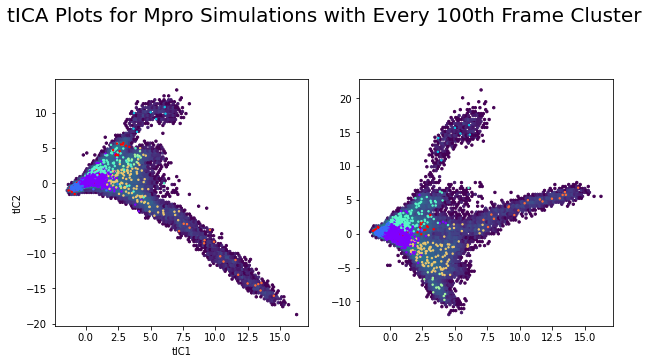

In [22]:
import glob, os, re
import pyemma
import mdtraj as md
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

# Now let's run our tICA / MSM again with CA distance features to get a better sense
# of global conformational changes.
# All we have to change here is the feature directory and output file descriptors, but we 
# can also play around with different numbers of clusters.
CA_stride = 8
tica_dir = f'tica_CA_stride_{CA_stride}' # directory to save results
feature_type=f'CA{CA_stride}_distances' # description of features
tica_lagtime = 100
n_components = 8
n_clusters = 8
msm_lagtime = 100
n_pdbs_to_save = 5 # per cluster
save_plots = True

# create some directories for output files
for sub_dir in ['plots', 'structures', 'objects', 'tIC_visualization']:
    if not os.path.exists(f'{tica_dir}/{sub_dir}'):
        os.makedirs(f'{tica_dir}/{sub_dir}')

features, traj_files = [],[]
feature_labels = np.load('Features/tica_features/feature_labels.npy')

features, traj_files = [],[]
# load in all the tica-ready featured data
for feature_file in glob.glob(f'Features/CA{CA_stride}_tica_features/*'):
    ident = re.sub('.npy','',re.sub(f'.*CA{CA_stride}_tica_features/','',feature_file))
    traj_files.append(ident)
    features.append(np.load(feature_file))
    
# performing tICA
tica_obj = tica(features, tica_lagtime, save=True,
  save_dir=f'{tica_dir}/objects', save_name=feature_type)
tica_output = tica_obj.get_output()
# fit the apo crystal data to our projection
apo_tica = tica_obj.fit_transform(np.load('Features/tica_features/Mpro.npy'))

# analyze eigenvectors to pick out top features
eigenvector_analysis(tica_obj, features, feature_labels)

# create trajectories along each of the tICs over 30 evenly spaced frames
visualize_tics(tica_output, frames=100, components=[[0,1],[1,0],[2,0],[3,0]])

# clustering in tICA space
cluster, cluster_centers, cluster_dtrajs = k_means(tica_output, n_clusters,
  max_iter=100, save=True, save_dir=f'{tica_dir}/objects', save_name=feature_type)
c = Counter(np.concatenate(cluster_dtrajs))
pops = [c[x]/len(np.concatenate(cluster_dtrajs)) for x in range(n_clusters)]

# generating MSM from tICA projection
msm = generate_msm(cluster, n_clusters, msm_lagtime, save=True,
  save_dir=f'{tica_dir}/objects', save_name=feature_type)

# saving pdbs for each cluster center
print(f'Saving {n_pdbs_to_save} closest frames to each cluster...')
center_frames, pdb_ndxs = find_cluster_center_structures(cluster_centers, tica_output,
  npdbs=n_pdbs_to_save)

for i in range(n_clusters):
    pop = int(pops[i]*100)
    for j in range(n_pdbs_to_save):
        traj_file = f'Trajectories/{traj_files[pdb_ndxs[i][j][0]]}/traj.xtc'
        gro_file = f'Trajectories/{traj_files[pdb_ndxs[i][j][0]]}/xtc.gro'
        frame = md.load_frame(traj_file, pdb_ndxs[i][j][1], top=gro_file)
        frame.save_pdb(f'{tica_dir}/structures/{traj_files[pdb_ndxs[i][j][0]]}_f{pdb_ndxs[i][j][1]}_c{i}_p{pop}.pdb')

# making & saving plots of tICA projections
coordinates = np.concatenate(np.asarray(tica_output))
cluster_colors = plt.get_cmap('rainbow')(np.linspace(0,1,n_clusters))
stride = 100
colors = [cluster_colors[c] for c in np.concatenate(cluster_dtrajs)[::stride]]
center_colors = [cluster_colors[c] for c in np.concatenate(cluster_dtrajs)[center_frames]]
legend_lines = [Line2D([0], [0], color=c, lw=4) for c in cluster_colors]

# plot tICA projection with cluster centers 
plt.figure(figsize=(10,10))
plt.suptitle(f'tICA Plots for Mpro Simulations With Cluster Centers', size=20)
for x,dims in enumerate([[0,1],[0,2],[1,2],[2,3]]):
    X = coordinates[:,dims[0]]
    Y = coordinates[:,dims[1]]
    plt.subplot(2,2,x+1)
    plt.hexbin(X, Y, bins='log')
    plt.scatter(np.concatenate(X[center_frames]), np.concatenate(Y[center_frames]),
      color=np.concatenate(center_colors), marker='*', s=24)
    if x == 1:
      plt.legend(legend_lines, [f'Cluster {n}, Pop: {pops[n]*100:.4f}'
        for n in range(n_clusters)], bbox_to_anchor=(1.05, 0.82, 0.3, 0.2), loc='upper left')
    plt.xlabel(f'tIC{dims[0]+1}')
    plt.ylabel(f'tIC{dims[1]+1}')
if save_plots:
    plt.savefig(f'{tica_dir}/plots/tica.png')
else:
    plt.show()
plt.close()

# plot initial simulation frames over the tICA projection
plt.figure(figsize=(10,10))
plt.suptitle(f'tICA Plots for Mpro Simulations With Initial Simulation Frames', size=20)
for x,dims in enumerate([[0,1],[0,2],[1,2],[2,3]]):
    X = coordinates[:,dims[0]]
    Y = coordinates[:,dims[1]]
    plt.subplot(2,2,x+1)
    plt.hexbin(X, Y, bins='log')
    for i in tica_output:
        plt.scatter(i[:,dims[0]][0], i[:,dims[1]][0], marker='*', color='k', s=8)
    plt.scatter(i[:,dims[0]][0], i[:,dims[1]][0], marker='*', color='k', s=8,
      label='Initial Frames')
    plt.xlabel(f'tIC{dims[0]+1}')
    plt.ylabel(f'tIC{dims[1]+1}')
    plt.legend()
if save_plots:
    plt.savefig(f'{tica_dir}/plots/tica_initial.png')
else:
    plt.show()
plt.close()

# plot apo crystal structures over the tICA projection
plt.figure(figsize=(10,10))
plt.suptitle(f'tICA Plots for Mpro Simulations With Apo Crystal Structures', size=20)
for x,dims in enumerate([[0,1],[0,2],[1,2],[2,3]]):
    X = coordinates[:,dims[0]]
    Y = coordinates[:,dims[1]]
    plt.subplot(2,2,x+1)
    plt.hexbin(X, Y, bins='log')
    plt.scatter(apo_tica[:,dims[0]], apo_tica[:,dims[1]], marker='*', color='k', s=8,
      label='Apo Crystal Structures')
    plt.xlabel(f'tIC{dims[0]+1}')
    plt.ylabel(f'tIC{dims[1]+1}')
    plt.legend()
if save_plots:
    plt.savefig(f'{tica_dir}/plots/tica_apo.png')
else:
    plt.show()
plt.close()

# plot strided clusters on top of tICA projection
plt.figure(figsize=(10,10))
plt.suptitle(f'tICA Plots for Mpro Simulations with Every {stride}th Frame Cluster', size=20)
for x,dims in enumerate([[0,1],[0,2],[1,2],[2,3]]):
    X = coordinates[:,dims[0]]
    Y = coordinates[:,dims[1]]
    plt.subplot(2,2,x+1)
    plt.hexbin(X, Y, bins='log')
    plt.scatter(X[::stride], Y[::stride], s=2, color=colors)
    if x == 1:
      plt.legend(legend_lines, [f'Cluster {n}, Pop: {msm.stationary_distribution[n]*100:.4f}'
        for n in range(n_clusters)], bbox_to_anchor=(1.05, 0.82, 0.3, 0.2), loc='upper left')
    plt.xlabel(f'tIC{dims[0]+1}')
    plt.ylabel(f'tIC{dims[1]+1}')
if save_plots:
    plt.savefig(f'{tica_dir}/plots/tica_clusters.png')
else:
    plt.show()
plt.close()

# plot the MSM transition matrix
fig = plt.figure(figsize=(13,6))
labels = [str(x) for x in range(n_clusters)]
ax = fig.add_subplot(121)
mat = ax.matshow(np.log10(msm.P), interpolation='nearest')
fig.colorbar(mat)
ax.set_xticklabels(['']+labels)
ax.set_yticklabels(['']+labels)
plt.title('MSM log10(P) Transition Matrix')

# plot the MSM MFPT matrix
mfpt_mat = np.zeros((n_clusters, n_clusters))
for i in range(n_clusters):
    for j in range(n_clusters):
        mfpt_mat[i][j] = np.log(msm.mfpt(i,j))

labels = [str(x) for x in range(n_clusters)]
ax = fig.add_subplot(122)
mat = ax.matshow(mfpt_mat, interpolation='nearest')
fig.colorbar(mat)
ax.set_xticklabels(['']+labels)
ax.set_yticklabels(['']+labels)
plt.title('MSM log10(MFPT) Matrix')
if save_plots:
    plt.savefig(f'{tica_dir}/plots/MSM_matrices.png')
else:
    plt.show()
plt.close()
np.save(f'{tica_dir}/objects/MFPT.npy',mfpt_mat)

Creating visualization of tIC1


FileNotFoundError: [Errno 2] No such file or directory: 'tica_CA_stride_4/tIC_visualization/tIC1.gro'

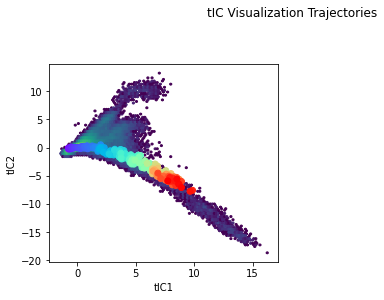

In [23]:
visualize_tics(tica_output, frames=200)

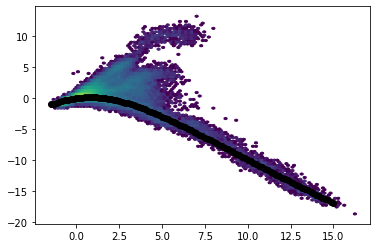

Creating visualization of tIC1


In [41]:
from scipy.interpolate import CubicSpline
frames = 100
x = [-1.5, 0, 5, 10, 15]
y = [-1, 0, -3, -10, -17]
f = CubicSpline(x, y, bc_type='natural')
x_new = np.linspace(-1.5, 15, frames)
y_new = f(x_new)

plt.hexbin(coordinates[:,0], coordinates[:,1], bins='log')
plt.scatter(x_new, y_new, color='k')
plt.show()

spline = np.zeros((frames,8))
spline[:,0] = x_new
spline[:,1] = y_new

visualize_tics(tica_output, components=[[0,1]], custom_spline=spline)

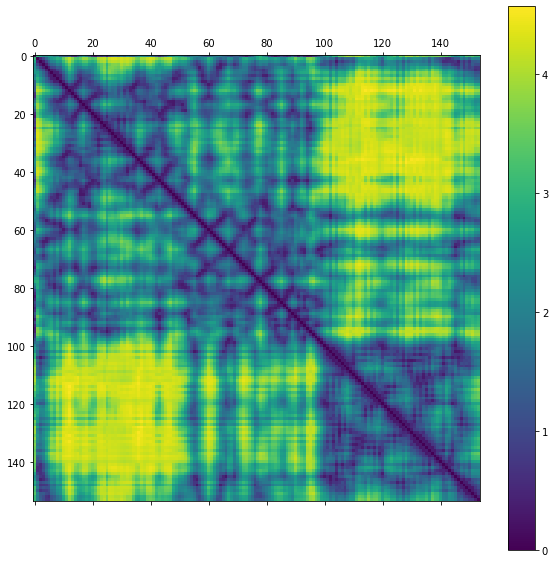

In [33]:
import mdtraj as md
import itertools
import numpy as np
from matplotlib import pyplot as plt

path = 'Trajectories/P14823_R2194_C0'
# load in trajectory
traj = md.load(f'{path}/traj.xtc',top=f'{path}/xtc.gro')
# get residue indices (there's probably a better way)
res_indices = list(set([r.index for a in traj.topology.residues]))[::2]
# get pairs of residue indices
pairs = itertools.product(res_indices, repeat=2)
# compute distances averaged over trajectory
contacts = np.average(md.compute_contacts(traj, contacts=list(pairs))[0], axis=0)
# re-shape to a matrix of n_res by n_res
contact_matrix = np.reshape(contacts, (len(res_indices), len(res_indices)))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
mat = ax.matshow(contact_matrix, interpolation='nearest')
fig.colorbar(mat)
plt.show()